In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import f1_score, precision_score, recall_score
from tensorflow.keras.models import load_model
from PIL import Image
import sys 
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.preprocessing import * 

train_generator, test_generator = train_test_generators()
model = load_model("models/best_model_v2_vgg16.h5")

Training Categories Labelled as: ['cataract', 'normal']
Found 491 images belonging to 2 classes.

Testing Categories Labelled as: ['cataract', '.DS_Store', 'normal']
Found 121 images belonging to 2 classes.

Class indices mapping: {'cataract': 0, 'normal': 1}


In [6]:
#Evaluation Report of the model
test_loss, test_accuracy, test_recall, test_precision, test_auc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Recall: {test_recall * 100:.2f}%')
print(f'Test Precision: {test_precision * 100:.2f}%')
print(f'Test AUC: {test_auc * 100:.2f}%')

4/4 [==============================] - 7s 2s/step - loss: 0.4169 - auc: 0.9995 - recall: 1.0000 - precision: 0.9375 - accuracy: 0.9669      
Test Accuracy: 99.95%
Test Recall: 100.00%
Test Precision: 93.75%
Test AUC: 96.69%


In [ ]:
#get the predictions for the test set
y_true = test_generator.classes
y_probs = model.predict(test_generator)

# threshold tuning 
for t in np.arange(0.2, 0.9, 0.05):
    preds = (y_probs > t).astype(int).flatten()
    f1 = f1_score(test_generator.classes, preds)
    precision = precision_score(test_generator.classes, preds)
    recall = recall_score(test_generator.classes, preds)
    print(f"Threshold: {t:.2f} | F1-score: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

4/4 [==============================] - 7s 2s/step
Threshold: 0.20 | F1-score: 0.9524 | Precision: 0.9091 | Recall: 1.0000
Threshold: 0.25 | F1-score: 0.9600 | Precision: 0.9231 | Recall: 1.0000
Threshold: 0.30 | F1-score: 0.9600 | Precision: 0.9231 | Recall: 1.0000
Threshold: 0.35 | F1-score: 0.9600 | Precision: 0.9231 | Recall: 1.0000
Threshold: 0.40 | F1-score: 0.9677 | Precision: 0.9375 | Recall: 1.0000
Threshold: 0.45 | F1-score: 0.9677 | Precision: 0.9375 | Recall: 1.0000
Threshold: 0.50 | F1-score: 0.9677 | Precision: 0.9375 | Recall: 1.0000
Threshold: 0.55 | F1-score: 0.9756 | Precision: 0.9524 | Recall: 1.0000
Threshold: 0.60 | F1-score: 0.9836 | Precision: 0.9677 | Recall: 1.0000
Threshold: 0.65 | F1-score: 0.9752 | Precision: 0.9672 | Recall: 0.9833
Threshold: 0.70 | F1-score: 0.9833 | Precision: 0.9833 | Recall: 0.9833
Threshold: 0.75 | F1-score: 0.9831 | Precision: 1.0000 | Recall: 0.9667
Threshold: 0.80 | F1-score: 0.9655 | Precision: 1.0000 | Recall: 0.9333
Threshold: 0.8

* Therefore, **Optimal Threshold = 0.60**
    - Recall = 1.0000 → No cataract case missed
    - Precision = 0.9677 → Very few false positives
    - F1-score = 0.9836 → Best balance

In [17]:
#get the predictions for the test set based on the optimal threshold
optimal_threshold = 0.6
y_preds = (y_probs > optimal_threshold).astype(int).flatten()
print("Prediction distribution:", np.unique(y_preds, return_counts=True))
print("True label distribution:", np.unique(test_generator.classes, return_counts=True))

print("\nClassification Report:")
classify_report = classification_report(
    y_true=y_true,
    y_pred=y_preds,
    target_names=test_generator.class_indices.keys(),
    zero_division=1  # avoid division-by-zero warning
)
print(classify_report)r

Prediction distribution: (array([0, 1]), array([59, 62]))
True label distribution: (array([0, 1], dtype=int32), array([61, 60]))

Classification Report:
              precision    recall  f1-score   support

    cataract       1.00      0.97      0.98        61
      normal       0.97      1.00      0.98        60

    accuracy                           0.98       121
   macro avg       0.98      0.98      0.98       121
weighted avg       0.98      0.98      0.98       121



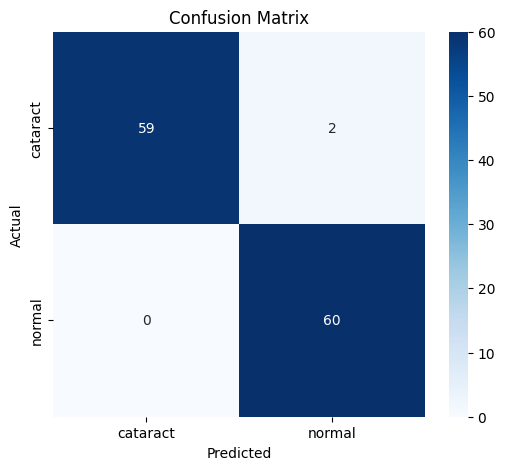

In [25]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

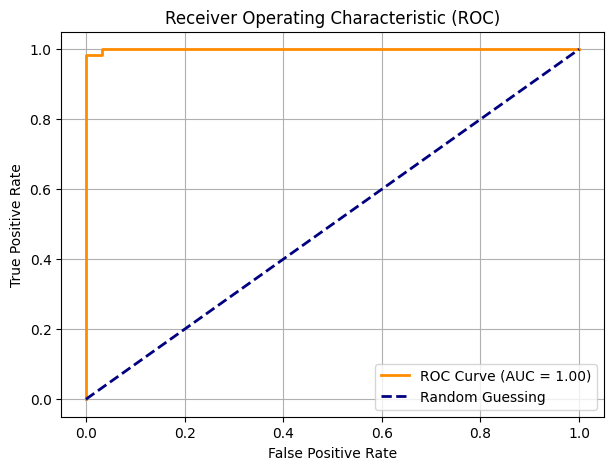

In [31]:
# --- ROC Curve & AUC ---
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = round(auc(fpr, tpr), 2)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


#### Testing on Sample image

1/1 [==============================] - 0s 71ms/step
Prediction: Cataract with 97.16% confidence


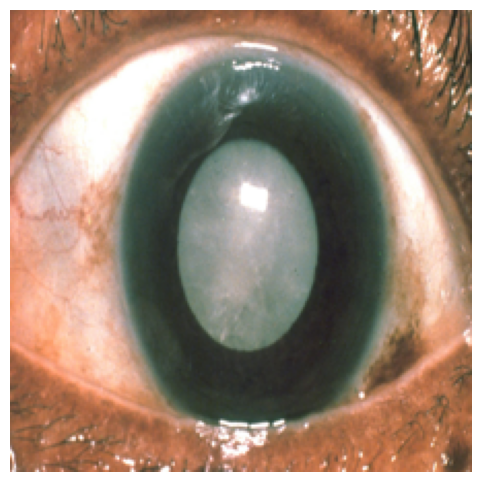

In [63]:
#load the image 
image = Image.open('/Users/muskaan2/ML_Dev/api/sample_images/test_cataract_img.png')
image = image.resize((224, 224)) 
image_array = np.array(image) / 255.0  
image_array = np.expand_dims(image_array, axis=0)

#make the prediction (optimal_threshold  set at 0.6 above)
prediction = model.predict(image_array)[0][0]
result = "Cataract" if prediction < optimal_threshold else "Normal"
confidence = round(float(1 - prediction if result == "Cataract" else prediction)*100, 2)
print(f"Prediction: {result} with {confidence}% confidence")

# Display the preprocessed image
plt.figure(figsize=(6, 6))
plt.imshow(image_array[0])
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 72ms/step
Prediction: Normal with 96.85% confidence


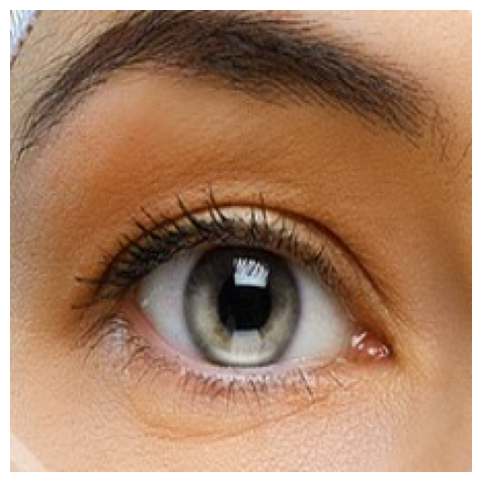

In [64]:
#load the image 
image = Image.open('/Users/muskaan2/ML_Dev/api/sample_images/test_normal_img.png')
image = image.resize((224, 224)) 
image_array = np.array(image) / 255.0  
image_array = np.expand_dims(image_array, axis=0)

#make the prediction (optimal_threshold  set at 0.6 above)
prediction = model.predict(image_array)[0][0]
result = "Cataract" if prediction < optimal_threshold else "Normal"
confidence = round(float(1 - prediction if result == "Cataract" else prediction)*100, 2)
print(f"Prediction: {result} with {confidence}% confidence")

# Display the preprocessed image
plt.figure(figsize=(6, 6))
plt.imshow(image_array[0])
plt.axis('off')
plt.show()
